<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/stochastics1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta python-binance

from binance.client import Client
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import ta
from tqdm import tqdm
import random
client = Client(None, None)

In [ ]:
symbol = "ETHUSDT"
#symbol = "DOGEUSDT"
#symbol = "SOLUSDT"
#symbol = "LTCUSDT"
#symbol = "LUNAUSDT"
#symbol = "BTCUSDT"
#symbol = "SHIBUSDT"

klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1MINUTE, "600 day ago")

o = []
h = []
l = []
c = []

for i in tqdm(klines):
    o.append(float(i[1]))
    h.append(float(i[2]))
    l.append(float(i[3]))
    c.append(float(i[4]))
    
data = {"Open":o, "High":h, "Low":l, "Close":c}
test = pd.DataFrame(data)
test


class minic:
    pass

sma21_raw = list(ta.trend.SMAIndicator(test["Close"], 21).sma_indicator())
sma50_raw = list(ta.trend.SMAIndicator(test["Close"], 50).sma_indicator())
sma200_raw = list(ta.trend.SMAIndicator(test["Close"], 200).sma_indicator())
rsi_14 = list(ta.momentum.RSIIndicator(test["Close"], 14).rsi())
rsi_2 = list(ta.momentum.RSIIndicator(test["Close"], 2).rsi())
rsi_4 = list(ta.momentum.RSIIndicator(test["Close"], 4).rsi())
atr_values = list(ta.volatility.AverageTrueRange(test["High"], test["Low"], test["Close"], 200).average_true_range())

candles_test = []

for i in tqdm(range(220,len(test))):
        new_candle = minic()
        o,h,l,c = test.iloc[i]
        new_candle.o = o
        new_candle.h = h
        new_candle.l = l
        new_candle.c = c
        new_candle.atr_value = atr_values[i]
        new_candle.sma21 = sma21_raw[i]
        new_candle.sma50 = sma50_raw[i]
        new_candle.sma200 = sma200_raw[i]
        new_candle.rsi14 = rsi_14[i]
        new_candle.rsi2 = rsi_2[i]
        new_candle.rsi4 = rsi_4[i]        
        candles_test.append(new_candle)
            
        

100%|██████████| 862452/862452 [01:10<00:00, 12178.95it/s]


In [ ]:
am = 4
rrw = 2
inc = 2
dec = 3
b = 0.9

wins = 0
losses = 0

omd = 0
ml = 0
pk = 0
all_balance = []
all_levs = []
candle_taken = []
for episode in tqdm(range(5)):
    
    balance = []
    levs = []
    cbalance = 0
    clvl = 1
    for _ in range(1):

        positions = []
        pos = -1
        balance.extend([cbalance for _ in range(episode)])
        
        for i in range(episode, len(candles_test)):
            c = candles_test[i].c
            h = candles_test[i].h
            l = candles_test[i].l
            o = candles_test[i].o

            atr = candles_test[i].atr_value * am

            while True:
              sth = False
              for o in range(len(positions)):
                if positions[o][0] == "S":
                  if h > positions[o][3]:
                    cbalance += (positions[o][3] - positions[o][1]) / positions[o][1] * positions[o][4]
                    del positions[o]
                    sth = True
                    losses+=1
                    clvl+=1
                    break
                  if l < positions[o][2]:
                    cbalance += (positions[o][2] - positions[o][1]) / positions[o][1] * positions[o][4]
                    del positions[o]
                    wins+=1
                    sth = True
                    clvl-=dec
                    pos = -1
                    break

                if positions[o][0] == "L":
                  if l < positions[o][3]:
                    cbalance += (positions[o][3] - positions[o][1]) / positions[o][1] * positions[o][4]
                    del positions[o]
                    sth = True
                    losses+=1
                    clvl+=1
                    break
                  if h > positions[o][2]:
                    cbalance += (positions[o][2] - positions[o][1]) / positions[o][1] * positions[o][4]
                    del positions[o]
                    sth = True
                    clvl-=dec
                    wins+=1
                    pos = -1
                    break

              if sth == False:
                break


            clvl = max(clvl,1)
            lev = 1*(inc**clvl)**(b**clvl)
            
            order_value = c/atr * lev* 0.005
            
            
            if len(positions) == 0:

                
                if pos == -1 and i not in candle_taken:
                    if candles_test[i].rsi2 < 10 and candles_test[i].rsi14 < 30:
                        pos = 1
                    elif candles_test[i].rsi2 > 90 and candles_test[i].rsi14 > 70:
                        pos = 0
                if pos == 0:
                      positions.append(["S", c,c - rrw * atr, c + 1 * atr, -order_value])
                      
                if pos == 1:
                      positions.append(["L", c,c + rrw * atr, c - 1 * atr, order_value])
                      
                if pos == 0 or pos == 1:
                    levs.append(lev)
                    candle_taken.append(i)
                    pass

            balance.append(cbalance)
            pk = max(cbalance, pk)
            ml = max(ml, lev * 1000 / (cbalance + 1000))
            omd = min(-(pk - cbalance), omd)

    all_balance.append(balance)
    all_levs.append(levs)
    
all_b_list = [np.sum([all_balance[y][x] for y in range(len(all_balance))]) for x in tqdm(range(len(all_balance[0])))]
#all_b_list = all_balance[0]

print("current:", all_b_list[-1])
print("w/l", wins, losses)
print("max l", ml)
print("max d", min(all_b_list))
print("total_max d", omd)
plt.figure(figsize = (20,3))
plt.plot(all_b_list)

 20%|██        | 1/5 [02:46<11:04, 166.08s/it]

In [ ]:
plt.figure(figsize = (20,3))
all_b_mean = [np.mean([all_balance[y][x] for y in range(len(all_balance))]) for x in tqdm(range(len(all_balance[0])))]
    
for i in all_balance:
    plt.plot(i, color="orange")
    
plt.plot(all_b_mean)

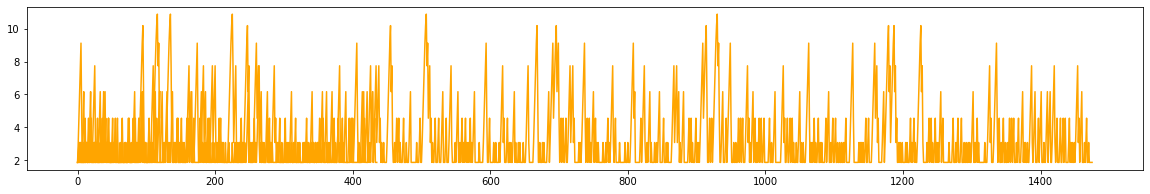

In [ ]:
plt.figure(figsize = (20,3))
    
for i in all_levs:
    plt.plot(i, color="orange")